In [ ]:
'''
# Abalone Age Prediction – Explainable ML (SHAP)

This project analyzes the UCI Abalone dataset using an XGBoost regression model and applies SHAP (SHapley Additive exPlanations) to interpret model predictions.

## Objectives
- Predict the number of rings (age proxy) of abalones using physical measurements
- Go beyond accuracy by explaining model decisions using SHAP
- Analyze feature interactions and local vs global explanations

## Methods
- Data preprocessing and feature encoding
- XGBoost regression model
- SHAP-based interpretability:
  - Local explanations (waterfall plots)
  - Global feature importance
  - Feature interaction analysis using SHAP dependence plots

## Key Insights
- Shell weight and shucked weight are the strongest contributors to age prediction
- Feature interactions play a significant role in model behavior
- SHAP reveals non-linear effects not visible through correlation analysis

## Tech Stack
- Python
- XGBoost
- SHAP
- Pandas, NumPy
- Matplotlib, Seaborn
'''



In [24]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.model_selection import train_test_split

import shap
shap.initjs()


In [2]:
data=pd.read_csv("abalone.csv",names=["sex","length","diameter","height","whole weight","shucked weight","viscera weight","shell weight","rings"])
print(data.head())


  sex  length  diameter  height  whole weight  shucked weight  viscera weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   shell weight  rings  
0         0.150     15  
1         0.070      7  
2         0.210      9  
3         0.155     10  
4         0.055      7  


Text(0.5, 0, 'whole weight')

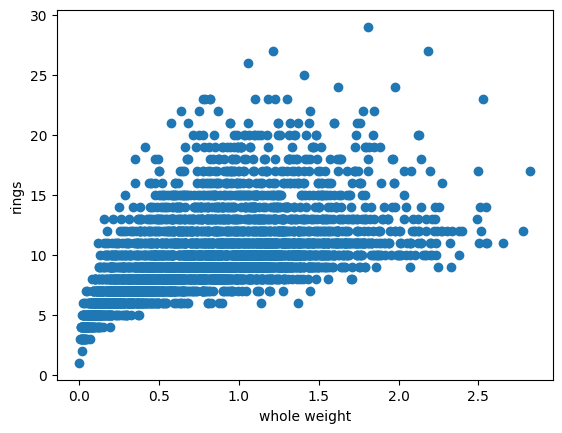

In [11]:
#plot: whole weight
plt.scatter(data['whole weight'],data['rings'])
plt.ylabel('rings')
plt.xlabel('whole weight')
#from the scatter plot we see that rings increases as whole weight increases

Text(0, 0.5, 'rings')

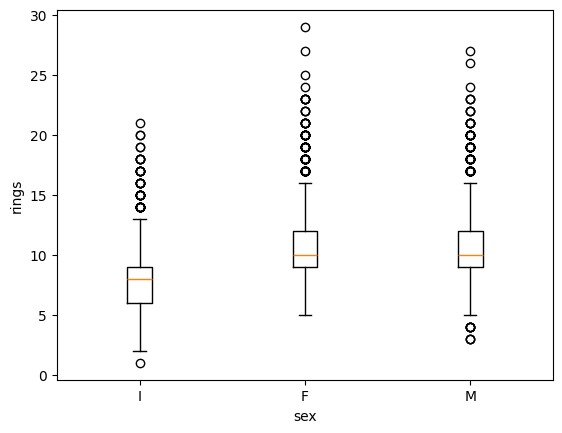

In [6]:
plt.boxplot(data[data.sex=='I']['rings'],positions=[1])
plt.boxplot(data[data.sex=='F']['rings'],positions=[2])
plt.boxplot(data[data.sex=='M']['rings'],positions=[3])
plt.xticks(ticks=[1,2,3],labels=['I','F','M'])
plt.xlabel('sex')
plt.ylabel('rings')

<Axes: >

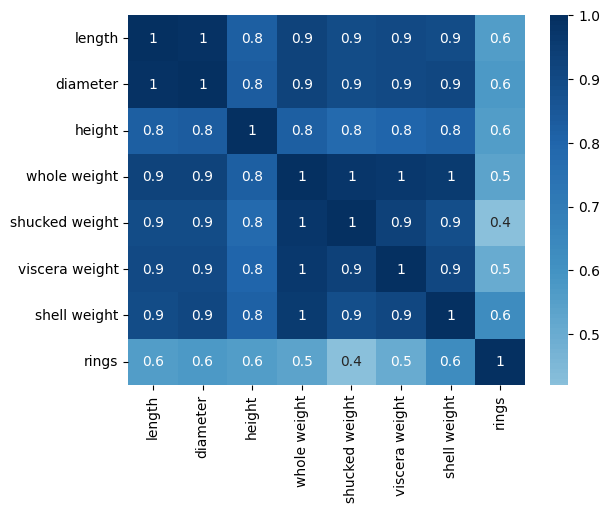

In [9]:
#correlation heat map
cont=["length","diameter","height","whole weight","shucked weight","viscera weight","shell weight","rings"]
corr_matrix=pd.DataFrame(data[cont],columns=cont).corr()
sns.heatmap(corr_matrix,cmap='RdBu',center=0,annot=True,fmt='.1g')


In [3]:
#Feature Engineering
y=data['rings']
X=data[['sex','length','height','shucked weight','viscera weight','shell weight']]

In [4]:
#create dummy variables
X = pd.get_dummies(X, columns=['sex'])   #using one hot encodings to convert categorical data into numerical values
X.head()

,length,height,shucked weight,viscera weight,shell weight,sex_F,sex_I,sex_M
0,0.455,0.095,0.2245,0.1010,0.150,False,False,True
1,0.350,0.090,0.0995,0.0485,0.070,False,False,True
2,0.530,0.135,0.2565,0.1415,0.210,True,False,False
3,0.440,0.125,0.2155,0.1140,0.155,False,False,True
4,0.330,0.080,0.0895,0.0395,0.055,False,True,False


In [5]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [6]:
#Train model
model=xgb.XGBRegressor(objective="reg:squarederror")
model.fit(X_train,y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

In [ ]:
#evaluating test data
model.score(X_test,y_test)


0.4639502167701721

Text(0.5, 0, 'Actual')

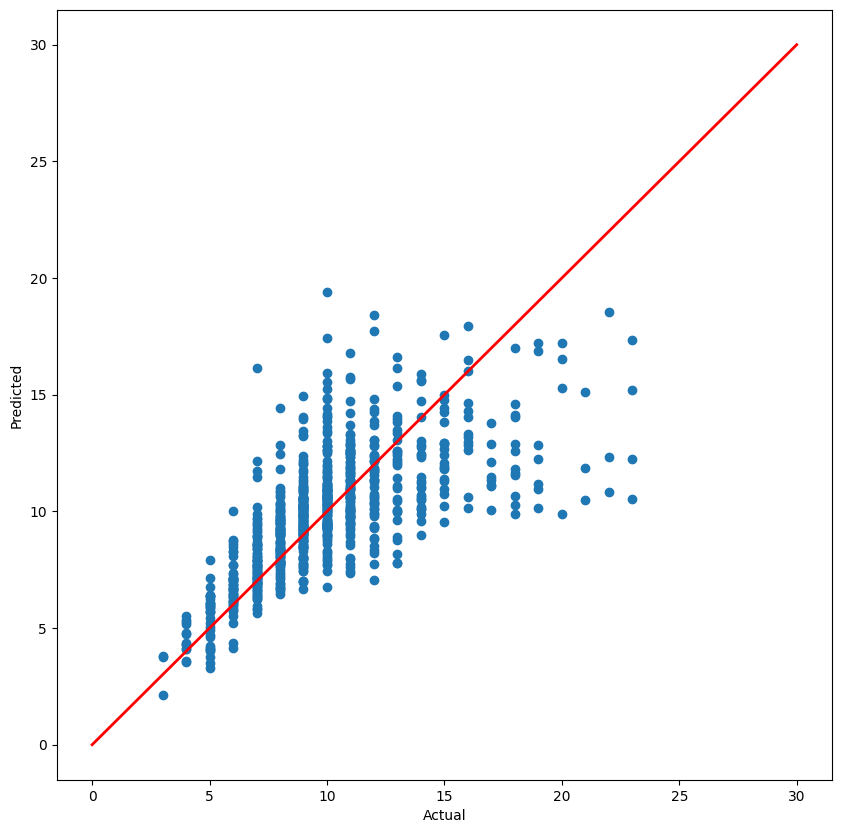

In [21]:
#get predictions
y_pred=model.predict(X_test)
#model evaluation
plt.figure(figsize=(10,10))
plt.scatter(y_test,y_pred)
plt.plot([0,30],[0,30],color='r',linestyle='-',linewidth=2)
plt.ylabel('Predicted')
plt.xlabel('Actual')


In [ ]:
#get shap values to see why these predictions were made
explainer=shap.Explainer(model)  #explainer is an object that knows how to explain your trained model.
shap_values=explainer(X_train)  #explainer gives the shap values

In [ ]:
np.shape(shap_values.values)
#(3341, 8) is the output meaning there are 8 shap values for each of the 3341 observations
#one shap value for each feature in our model

(3341, 8)

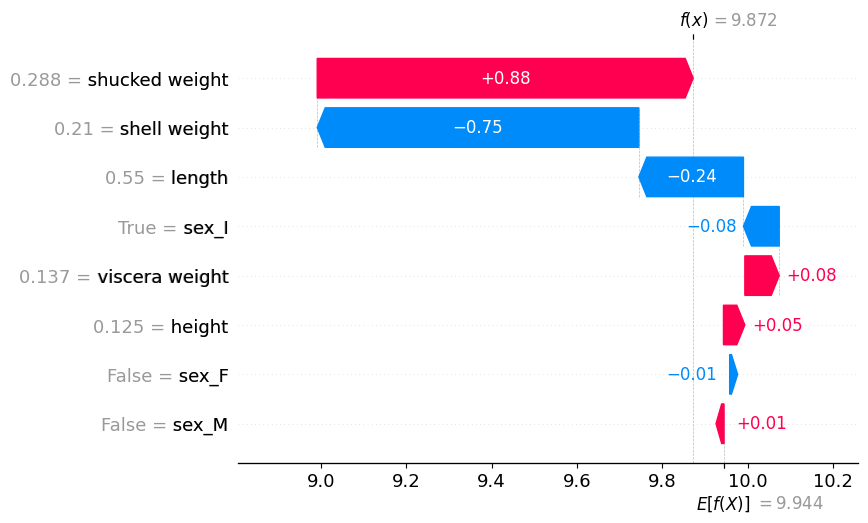

'The SHAP waterfall shows that while shucked weight strongly increases the predicted age, \nlower shell weight and length counteract this effect, resulting in a slightly below-average predicted number of rings.'

In [28]:
#waterfall plot
shap.plots.waterfall(shap_values[0]) #shap_values for the first observation

'''The SHAP waterfall shows that while shucked weight strongly increases the predicted age, 
lower shell weight and length counteract this effect, resulting in a slightly below-average predicted number of rings.'''

In [30]:
shap.plots.force(shap_values[0])

In [ ]:
#stacked force plot
shap.plots.force(shap_values[0:100])  #passing first 100 observations
#each individual force plot is flipped by 90 degrees and stacked side by side


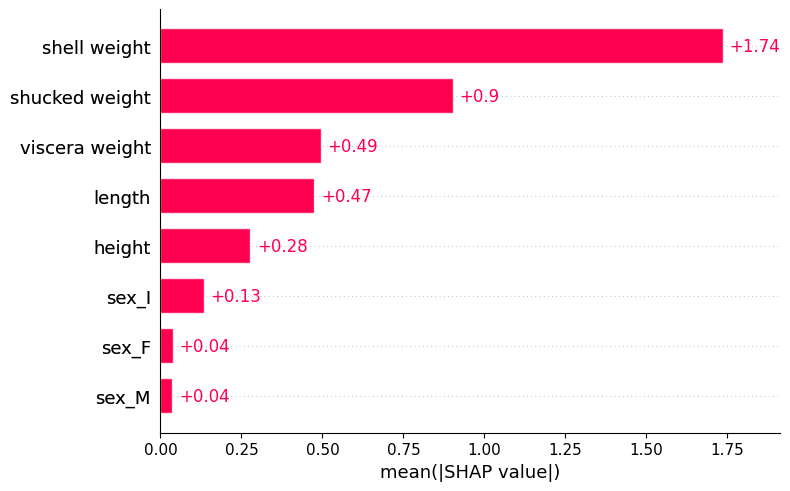

In [32]:
#absolute mean shap
shap.plots.bar(shap_values)

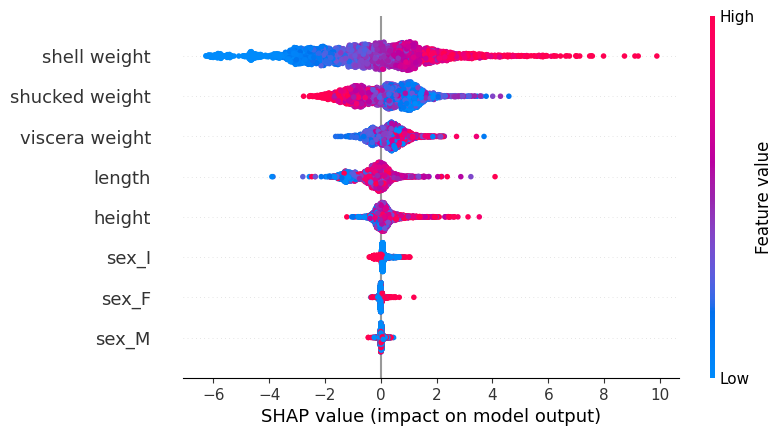

In [33]:
shap.plots.beeswarm(shap_values)

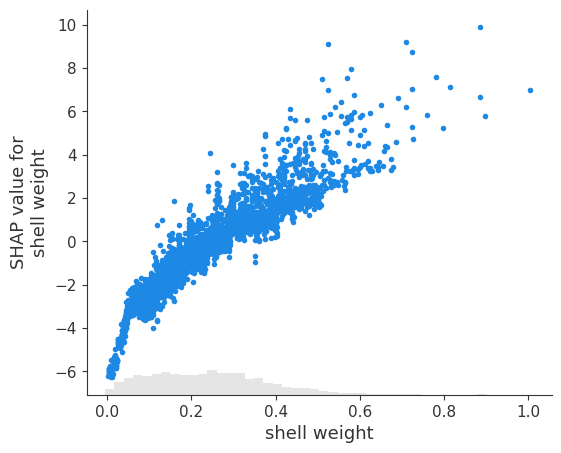

In [34]:
shap.plots.scatter(shap_values[:,"shell weight"])

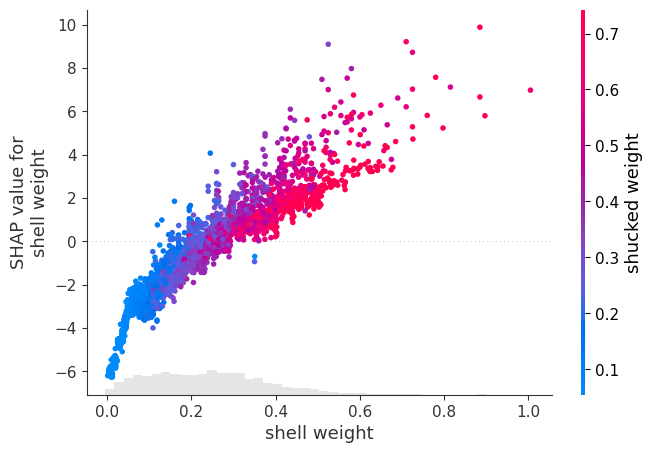

In [35]:
shap.plots.scatter(shap_values[:,"shell weight"],color=shap_values[:,"shucked weight"])

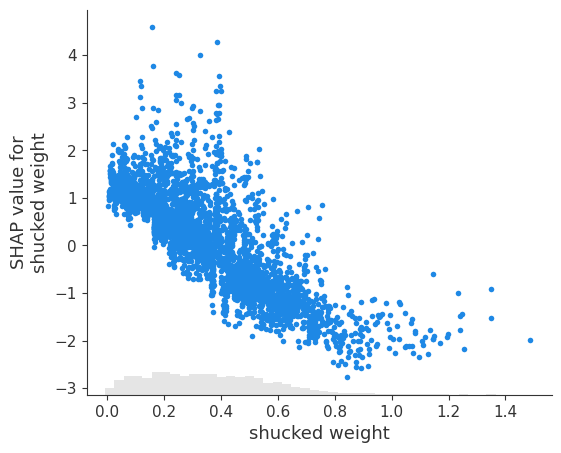

In [36]:
shap.plots.scatter(shap_values[:,"shucked weight"])